In [33]:
import findspark
findspark.init()
import pyspark # Call this only after findspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

#from pyspark.sql import SparkSession
import numpy as np
import pandas as pd

#import nltk
#need to manuall download 'punkt' before using this : nltk.download('punkt')
from nltk.corpus import (stopwords)

#import for Natural language Processing(NLP) sentiment analysis library
from textblob import TextBlob

#for os commands
import os

#for wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#import sklearn
from sklearn.feature_extraction.text import (
    CountVectorizer)

import collections
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)


In [34]:

class extractHDFS():
    """
    To read from HDFS
    """

    def readHDFS(self):

        sc = SparkContext.getOrCreate()
        spark = SparkSession(sc)

        #test sparkcontext
        #print(spark)

        #https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html
        #entry point for spark to interact with spark's functions
        sparkSession = SparkSession.builder.appName("test_read_from_hdfs").getOrCreate()

        #path to tweets text file in hadoop hdfs
        data="hdfs://namenode:9000/user/test/input/tweets_pg_export.txt"

        #https://stackoverflow.com/questions/49471192/spark-2-3-0-read-text-file-with-header-option-not-working
        #load text file into Spark dataframes
        df_load = sparkSession.read.option("header", "true").csv(data)

        #test and print 2 rows of Spark dataframe
        #df_load.show(2, False)

        # Enable Arrow-based columnar data transfers
        spark.conf.set("spark.sql.execution.arrow.enabled", "true")

        #conver Spark dataframe into Pandas dataframe
        df_pandas = df_load.select("*").toPandas()

        #print(df_pandas)
        
        return df_pandas

In [35]:
class data_preparation():
    """
    To clean tweets and remove words that we don't need for analysis
    """

    def preprocessing(self,df_pandas):

        #change tweets into lowercase
        df_pandas['tweet_text'] = df_pandas['tweet_text'].str.lower()
        #Removing RT retweet term
        df_pandas['tweet_text'] = df_pandas['tweet_text'].str.replace('rt', '')
        #Removing usernames
        df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'@\w+', '', regex=True)
        #Removing url links
        df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'http\S+', '', regex=True)
        df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'www.[^ ]+', '', regex=True)
        #remove next line \n
        df_pandas['tweet_text'] = df_pandas['tweet_text'].replace('\n',' ', regex=True)
        #remove numbers
        df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'[0-9]+', '', regex=True)
        #removing special characters
        df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
        # Removing tweet topic
        df_pandas['tweet_text'] = df_pandas['tweet_text'].str.replace('haze', '')


        return df_pandas
    
    
    def remove_stopwords(self,df_pandas):
        """
        Stopwords like the,a,in,an will bring no value to our analysis and it should be removed.
        """

        #https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

        #removing stop words such as "the,a,in,an"
        stop_words_eng = stopwords.words('english')

        #lamda a type of hidden function or anonymous function written in one line instead of writing a new function
        #apply is used to apply the lamda function on one column
        #split the tweet using space in x.split() then check for if its not a stop word then join it together again with space
        #and move on to the next word of the tweet

        df_pandas['tweet_text'] = df_pandas['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_eng)]))

        return df_pandas

In [36]:
class wordcloud():
    """
    to generate wordcloud based on sentiment value positive, negative and both positive and negative.
    """

    def wordclouddraw(self,df_pandas,sent):


        if sent == 'positive':

            #https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
            text_filtered_sentiment = df_pandas['sentiment'] == 1
            text_filtered_sentiment2 = df_pandas[text_filtered_sentiment]
            text = text_filtered_sentiment2.tweet_text.to_string(index=False, header=False)
            filename = "/HAZE_pos_tweets.png"

        elif sent == 'negative':

            text_filtered_sentiment = df_pandas['sentiment'] == -1
            text_filtered_sentiment2 = df_pandas[text_filtered_sentiment]
            text = text_filtered_sentiment2.tweet_text.to_string(index=False, header=False)
            filename = "/HAZE_neg_tweets.png"

        else:
            #this includes both positive and negative tweets
            text = df_pandas.tweet_text.to_string( index=False, header=False)
            filename = "/HAZE_all_tweets.png"



        file = os.getcwd()


        wordcloud = WordCloud(
            width = 1500,
            height = 1000,
            background_color = 'black',
            #stopwords = STOPWORDS
            stopwords=['haze']
        ).generate(text)
        #generate(' '.join(str(df['tweet_text']))
        fig = plt.figure(
            figsize = (20, 10),
            facecolor = 'k',
            edgecolor = 'k')
        plt.imshow(wordcloud, interpolation = 'bilinear')#'hermite'
        plt.axis('off')
        plt.tight_layout(pad=0)

        wcpath=file+filename

        wordcloud.to_file(wcpath)

In [37]:
class sentimentanalysis():
    """
    to convert sentiment score generated from TextBlob library into 1,-1 or 0 based on sentiment score.
    """

    def analyse_sentiment(self, df_pandas):


        sentiment = df_pandas

        if sentiment > 0:
            return 1
        elif sentiment == 0:
            return 0
        else:
            return -1

In [38]:
class wordfreq():

    """
    to generate a graph based on word frequency
    """

    def vectorization(self, df_pandas, sent2):
        # https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27

        countv = CountVectorizer()
        bow = countv.fit_transform(df_pandas.tweet_text)
        word_freq = dict(zip(countv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
        word_counter = collections.Counter(word_freq)
        word_counter_df = pd.DataFrame(word_counter.most_common(30), columns=['word', 'freq'])

        
#https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib

        file = os.getcwd()
        title = "Word Frequency for %s tweets" % sent2
        fig, ax = plt.subplots(figsize=(10, 12))
        sns.barplot(x="freq", y="word", data=word_counter_df, palette="PuBuGn_d", ax=ax)

        plt.xticks(
            rotation=90,
            horizontalalignment='right',
            fontweight='light',
            #fontsize='x-large'
            size = 14
        )

        plt.xlabel("Frequency", size=14);
        plt.ylabel("30 more frequent words", size=14);

        plt.title(title, size=18)
        plt.grid(False);
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);




        filename = "/HAZE_graph_%s_spark.png" %sent2
        graphpath = file + filename
        plt.savefig(graphpath, format="png")

/usr/local/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


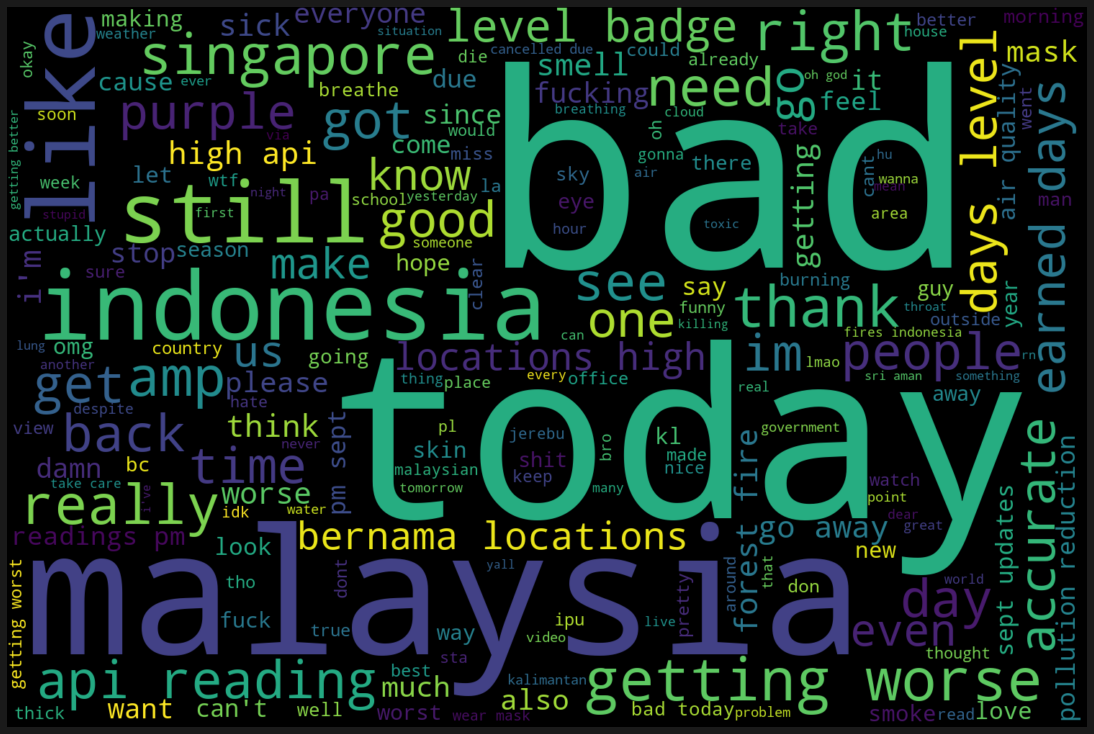

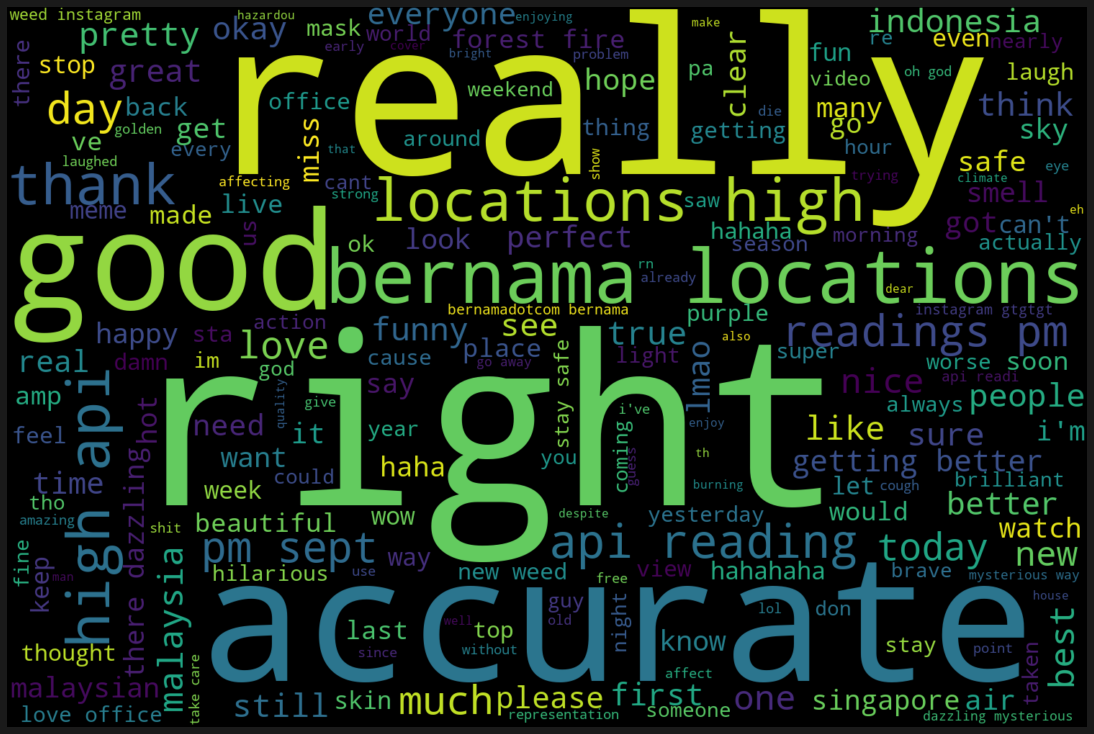

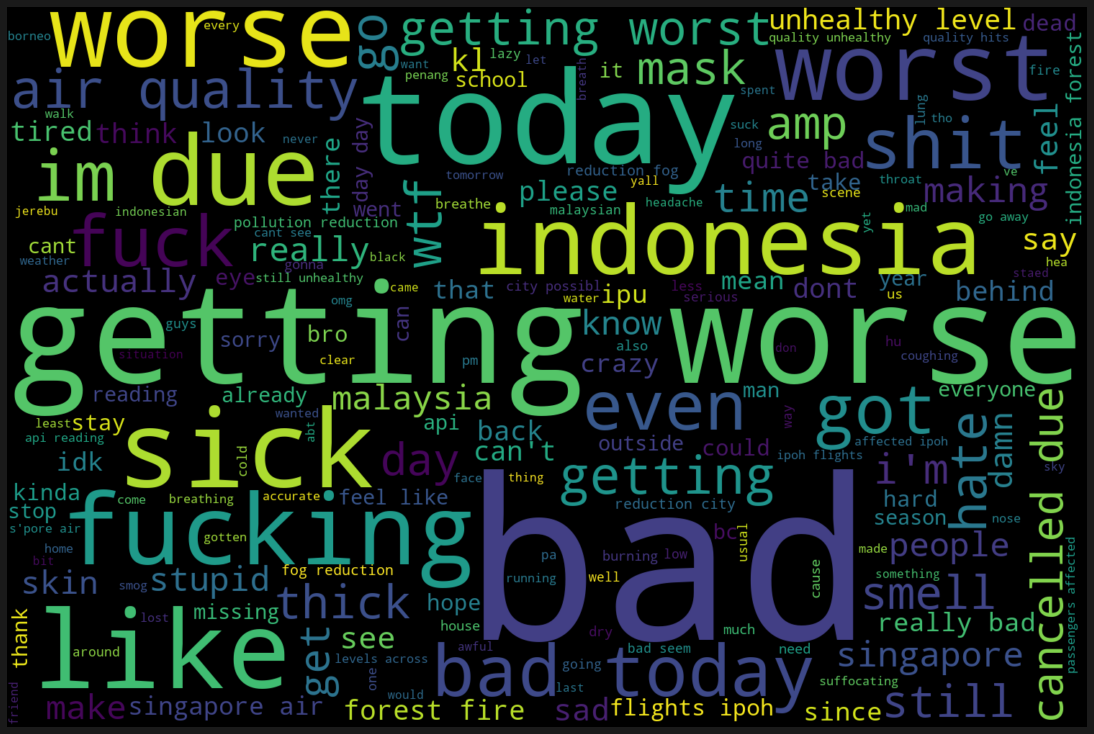

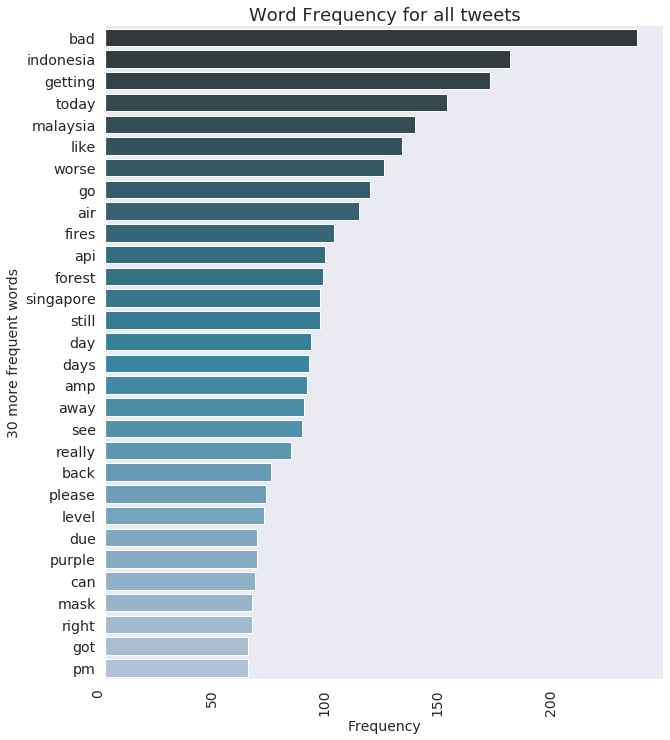

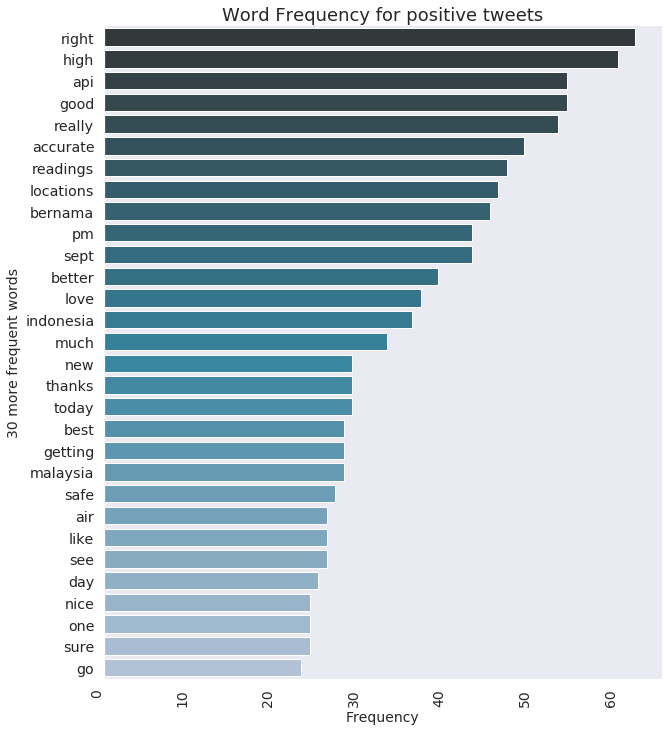

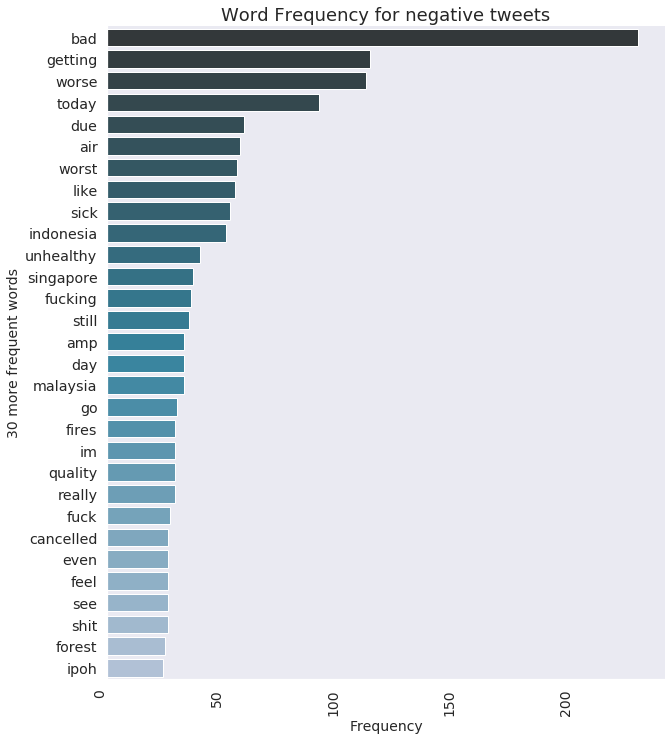

In [39]:
if __name__ == '__main__':


    readHDFSfile = extractHDFS()
    datapreparation = data_preparation()
    genwordcloud = wordcloud()
    senti=sentimentanalysis()
    wf = wordfreq()

    #read from hdfs
    df_pandas = readHDFSfile.readHDFS()
    
    #data preprocessing and cleaning
    datapreparation.preprocessing(df_pandas)
    datapreparation.remove_stopwords(df_pandas)


    #https: // stackoverflow.com / questions / 54588807 / loop - to - retrieve - sentiment - analysis - in -pandas - core - series - series
    #add sentiment score into a new column in dataframe
    df_pandas['sentiment'] = df_pandas.tweet_text.apply(lambda tweet_text: TextBlob(tweet_text).sentiment.polarity)

    #convert sentiment score into 1(positive),-1(negative) or 0(neutral)
    df_pandas['sentiment'] = np.array([senti.analyse_sentiment(df_pandas) for df_pandas in df_pandas['sentiment']])

    #Wordcloud all, positive, negative
    genwordcloud.wordclouddraw(df_pandas, sent="all")
    genwordcloud.wordclouddraw(df_pandas, sent="positive")
    genwordcloud.wordclouddraw(df_pandas, sent="negative")


    # Graph with frequency words all, positive and negative tweets and get the frequency
    wf.vectorization(df_pandas, sent2="all")
    wf.vectorization(df_pandas[df_pandas['sentiment'] == 1], sent2="positive")
    wf.vectorization(df_pandas[df_pandas['sentiment'] == -1], sent2="negative")


